# Pregunta 2:
### ¿Podemos identificar clusters o grupos naturales de películas blockbuster según características de género, presupuesto y rating?
# Técnica:
### Análisis mediante K-Means Clustering (Aprendizaje No Supervisado)

## 1. Configuración inicial

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import os
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Crear carpeta para gráficos de esta pregunta
graphics_folder = 'graphics/pregunta2'
if not os.path.exists(graphics_folder):
    os.makedirs(graphics_folder)
    print(f"✓ Carpeta creada: {graphics_folder}/")

# Crear carpeta para resultados
results_folder = 'results'
if not os.path.exists(results_folder):
    os.makedirs(results_folder)
    print(f"✓ Carpeta creada: {results_folder}/")

## 2. Cargar datos limpios

In [20]:
print("📂 CARGANDO DATOS PROCESADOS...")
try:
    # Intentar cargar desde la carpeta data
    df = pd.read_csv('data/Blockbusters_Limpio.csv')
    print(f"✓ Datos limpios cargados exitosamente desde: data/Blockbusters_Limpio.csv")
    print(f"  • {df.shape[0]} películas, {df.shape[1]} variables")
    
    # Verificar que tenemos las columnas necesarias
    required_columns = ['film_budget', 'imdb_rating', 'genre_1']
    missing_columns = [col for col in required_columns if col not in df.columns]
    
    if missing_columns:
        print(f"⚠ Advertencia: Faltan columnas {missing_columns}")
            
except FileNotFoundError:
    print("⚠ No se encontró el archivo limpio, cargando original...")
    try:
        df = pd.read_csv('Blockbusters_2019-1977.csv', encoding='latin1')
        
        # Limpiar columnas numéricas
        columnas_numericas = ['film_budget', 'worldwide_gross', 'domestic_gross']
        for col in columnas_numericas:
            if col in df.columns:
                df[col] = df[col].astype(str).str.replace(',', '').str.replace('$', '')
                df[col] = pd.to_numeric(df[col], errors='coerce')
        
        print("✓ Datos originales cargados y transformados")
        
    except FileNotFoundError:
        print("❌ ERROR: No se encontró ningún archivo de datos")
        print("  Por favor, ejecuta primero Analisis_Blockbusters_Main.ipynb")
        raise

📂 CARGANDO DATOS PROCESADOS...
✓ Datos limpios cargados exitosamente desde: data/Blockbusters_Limpio.csv
  • 430 películas, 18 variables


## 3. Descripción de variables y metodología

## Variables utilizadas

El análisis de clustering se realizó sobre un subconjunto de variables del conjunto de datos Blockbusters (1977–2019), seleccionadas por su relevancia analítica y su capacidad para capturar dimensiones clave de las películas. En particular, se incluyeron variables económicas, de calidad percibida y de tipo narrativo.

El presupuesto de la película (film_budget) se utilizó como variable numérica continua y representa la escala económica de la producción, así como el nivel de inversión por parte de los estudios. En el caso de los blockbusters, este presupuesto suele situarse típicamente entre 20 y 300 millones de dólares, lo que lo convierte en un factor central para diferenciar estrategias de producción.

La calificación de IMDb (imdb_rating), también de naturaleza numérica, refleja la recepción del público a partir de valoraciones de usuarios en una escala de 1 a 10. Esta variable se interpreta como una medida de la calidad percibida de la película, asociada a aspectos como el guion, la dirección y las actuaciones, y resulta particularmente relevante porque no depende directamente del nivel de inversión.

Finalmente, se incorporó el género principal de la película (genre_1) como variable categórica, ya que describe el tipo narrativo dominante. El género es una dimensión clave en la industria cinematográfica, dado que algunos géneros tienden a asociarse sistemáticamente con mayores presupuestos y diferentes perfiles de audiencia, como ocurre, por ejemplo, con la ciencia ficción frente al drama.

## Justificación de la metodología

Se optó por aplicar un análisis de clustering no supervisado debido al carácter exploratorio del estudio. No se cuenta con etiquetas predefinidas que clasifiquen a las películas en “tipos de blockbuster”, por lo que el objetivo es identificar patrones naturales en los datos sin imponer categorías a priori.

Además, las películas blockbuster presentan una naturaleza multidimensional, ya que difieren simultáneamente en presupuesto, calidad percibida y género. El clustering permite capturar estas variaciones conjuntas y analizar cómo se combinan estas características, algo que no puede lograrse mediante análisis univariados o bivariados.

Por último, se espera una alta heterogeneidad dentro del conjunto de blockbusters. Existen películas con presupuestos extremadamente altos pero recepción crítica moderada, otras con presupuestos más contenidos y excelente valoración, y otras que, pese a una inversión menor, logran una gran aceptación popular. El clustering permite identificar estos perfiles diferenciados de manera empírica.

## Algoritmo de clustering: K-Means

Para la segmentación se utilizó el algoritmo K-Means, debido a su eficiencia computacional y a su facilidad de interpretación. Este método resulta adecuado para conjuntos de datos con cientos de observaciones y permite describir cada grupo mediante centroides que representan valores promedio de presupuesto y calificación, lo cual facilita la comunicación de los resultados.

K-Means es ampliamente utilizado en contextos de segmentación industrial y de mercado, incluido el análisis de productos culturales como las películas, lo que refuerza su pertinencia para este estudio.

## 4. Preprocesamiento y selección de K óptimo

In [29]:
print("\n" + "="*70)
print("PREPROCESAMIENTO Y SELECCIÓN DE K ÓPTIMO ")
print("="*70)

# LIMPIEZA CRÍTICA - Convertir presupuesto a numérico
df['film_budget'] = (
    df['film_budget']
    .astype(str)
    .str.replace(',', '')
    .astype(float)
)
print("✓ Presupuesto convertido a numérico")

# Selección de variables
df_cluster = df[['film_budget', 'imdb_rating', 'genre_1']].dropna()

print(f"✓ Datos preparados: {len(df_cluster)} películas")
print(f"  • {len(df) - len(df_cluster)} películas descartadas por datos incompletos")

# Variables dummy para el género principal
df_cluster = pd.get_dummies(
    df_cluster,
    columns=['genre_1'],
    drop_first=True
)

print("✓ Variables dummy creadas para genre_1")

# Escalado de variables numéricas
scaler = StandardScaler()
df_cluster[['film_budget', 'imdb_rating']] = scaler.fit_transform(
    df_cluster[['film_budget', 'imdb_rating']]
)

print("✓ Variables numéricas estandarizadas")

# Matriz final para clustering
X_cluster = df_cluster.values


sil_scores = {}
davies_bouldin_scores = {}
calinski_harabasz_scores = {}

print("\nEvaluando k de 2 a 6...")

for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_cluster)

    sil = silhouette_score(X_cluster, labels)
    db = davies_bouldin_score(X_cluster, labels)
    ch = calinski_harabasz_score(X_cluster, labels)

    sil_scores[k] = sil
    davies_bouldin_scores[k] = db
    calinski_harabasz_scores[k] = ch

    print(f"  k={k}: Silhouette={sil:.3f}, Davies-Bouldin={db:.3f}, Calinski-Harabasz={ch:.1f}")

best_k = max(sil_scores, key=sil_scores.get)

print(f"\n✓ MEJOR NÚMERO DE CLUSTERS: {best_k}")
print(f"  Silhouette score: {sil_scores[best_k]:.3f}")
print(f"  Davies-Bouldin Index: {davies_bouldin_scores[best_k]:.3f}")
print(f"  Calinski-Harabasz Index: {calinski_harabasz_scores[best_k]:.1f}")


PREPROCESAMIENTO Y SELECCIÓN DE K ÓPTIMO 
✓ Presupuesto convertido a numérico
✓ Datos preparados: 430 películas
  • 0 películas descartadas por datos incompletos
✓ Variables dummy creadas para genre_1
✓ Variables numéricas estandarizadas

Evaluando k de 2 a 6...
  k=2: Silhouette=0.303, Davies-Bouldin=1.296, Calinski-Harabasz=195.5
  k=3: Silhouette=0.287, Davies-Bouldin=1.151, Calinski-Harabasz=215.0
  k=4: Silhouette=0.267, Davies-Bouldin=1.191, Calinski-Harabasz=191.6
  k=5: Silhouette=0.240, Davies-Bouldin=1.303, Calinski-Harabasz=180.2
  k=6: Silhouette=0.255, Davies-Bouldin=1.245, Calinski-Harabasz=165.8

✓ MEJOR NÚMERO DE CLUSTERS: 2
  Silhouette score: 0.303
  Davies-Bouldin Index: 1.296
  Calinski-Harabasz Index: 195.5


In [ ]:
#Generar las tablas de los 3 parametros !!!

## Validación del número óptimo de clusters

Para determinar el número óptimo de clusters, se emplearon tres métricas de validación complementarias: el Coeficiente de Silueta, el Índice de Davies-Bouldin y el Índice de Calinski-Harabasz. Cada una evalúa la calidad del clustering desde una perspectiva diferente, considerando la cohesión interna de los grupos y su separación entre sí.

El número final de clusters se seleccionó considerando el consenso entre estas métricas, es decir, aquel valor de k para el cual se obtiene simultáneamente un coeficiente de silueta elevado, un índice de Davies-Bouldin reducido y un índice de Calinski-Harabasz alto. Este enfoque garantiza una elección robusta y estadísticamente fundamentada del número de grupos.

## 5. Análisis y caracterización de clusters

## 6. Visualizaciones

In [32]:
# Gráfico 2: Scatter plot - Presupuesto vs Rating CON DESCRIPCIONES DE CLUSTERS
fig = plt.figure(figsize=(14, 8))

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']
for c in sorted(X['Cluster'].unique()):
    subset = X[X['Cluster'] == c]
    subset_orig = df_analysis.loc[subset.index]
    
    # Usar nombre descriptivo del cluster
    label = f'{cluster_names[c]} (n={len(subset)})'
    
    plt.scatter(
        subset_orig['film_budget'],
        subset_orig['imdb_rating'],
        label=label,
        s=80,
        alpha=0.6,
        color=colors[c % len(colors)]
    )

plt.xlabel('Presupuesto ($)', fontsize=12, fontweight='bold')
plt.ylabel('IMDb Rating', fontsize=12, fontweight='bold')
plt.title(f'Clustering de Películas Blockbuster (K={best_k})\nPresupuesto vs Rating IMDb', 
          fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=9, framealpha=0.95)
plt.grid(True, alpha=0.3)
plt.ticklabel_format(style='plain', axis='x')

# Guardar gráfico
ruta_scatter = os.path.join(graphics_folder, '02_Clusters_Presupuesto_vs_Rating.png')
plt.savefig(ruta_scatter, dpi=300, bbox_inches='tight')
print(f"✓ Guardado: {ruta_scatter}")
plt.show()
plt.close()

KeyError: 'Cluster'

<Figure size 1400x800 with 0 Axes>

✓ Guardado: graphics/pregunta2\03_Boxplots_Caracteristicas_por_Cluster.png


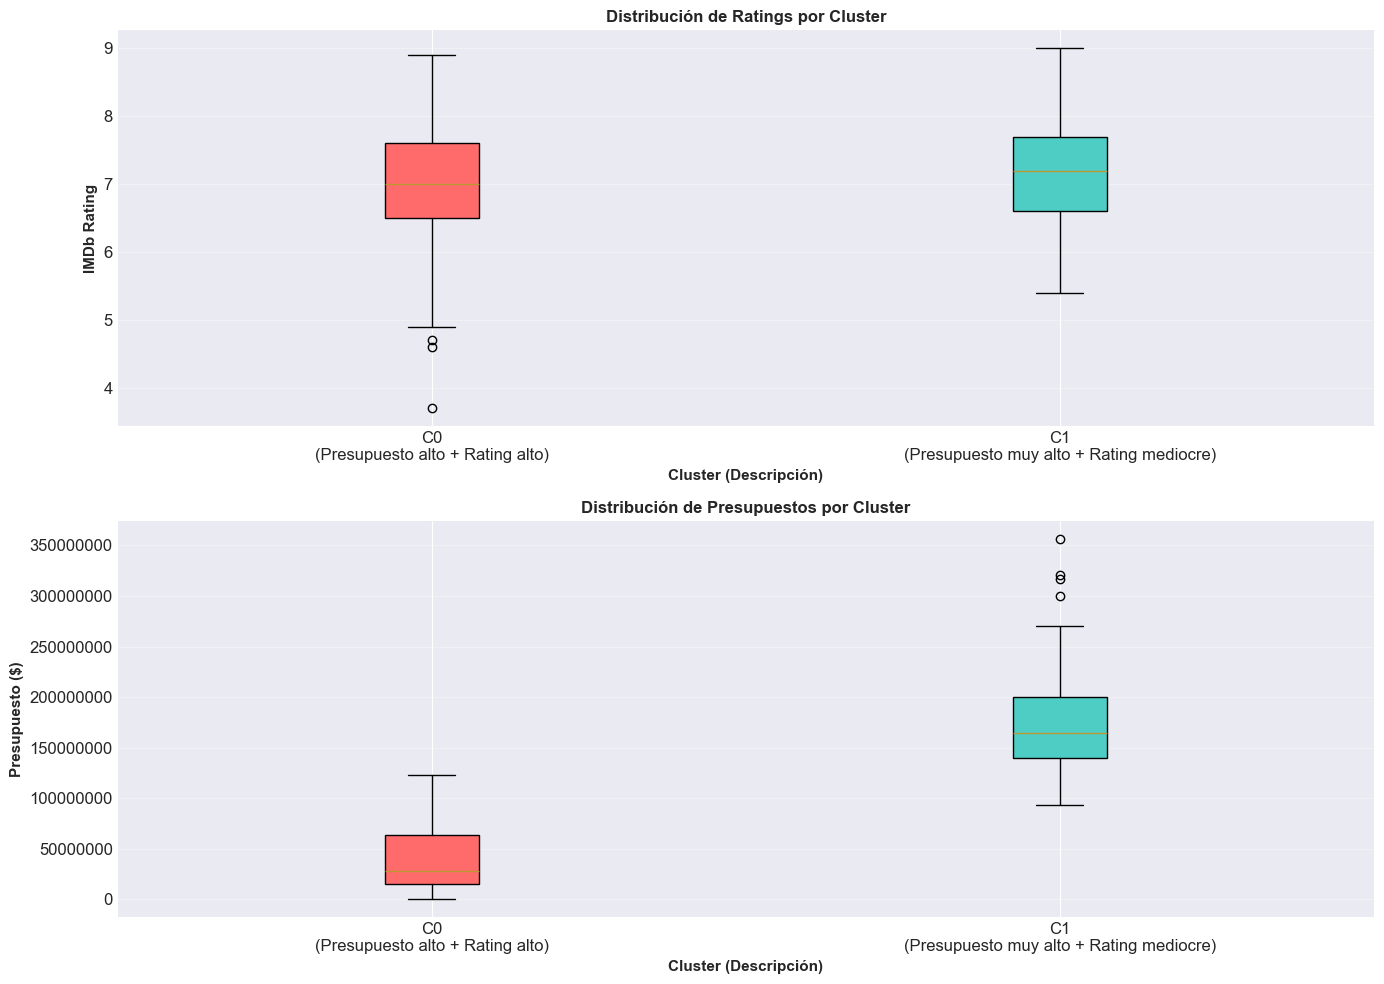

In [46]:
# Gráfico 3: Boxplots por cluster CON NOMBRES DESCRIPTIVOS
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Boxplot de Rating por cluster
ax1 = axes[0]
cluster_rating_data = [df_analysis[df_analysis['Cluster'] == c]['imdb_rating'].values 
                       for c in sorted(df_analysis['Cluster'].unique())]
cluster_labels = [f"C{c}\n{cluster_names[c].split(chr(10))[1]}" 
                  for c in sorted(df_analysis['Cluster'].unique())]
bp1 = ax1.boxplot(cluster_rating_data, 
                    labels=cluster_labels,
                    patch_artist=True)
for patch, color in zip(bp1['boxes'], colors):
    patch.set_facecolor(color)
ax1.set_ylabel('IMDb Rating', fontsize=11, fontweight='bold')
ax1.set_xlabel('Cluster (Descripción)', fontsize=11, fontweight='bold')
ax1.set_title('Distribución de Ratings por Cluster', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Boxplot de Presupuesto por cluster
ax2 = axes[1]
cluster_budget_data = [df_analysis[df_analysis['Cluster'] == c]['film_budget'].values 
                       for c in sorted(df_analysis['Cluster'].unique())]
bp2 = ax2.boxplot(cluster_budget_data,
                   labels=cluster_labels,
                   patch_artist=True)
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
ax2.set_ylabel('Presupuesto ($)', fontsize=11, fontweight='bold')
ax2.set_xlabel('Cluster (Descripción)', fontsize=11, fontweight='bold')
ax2.set_title('Distribución de Presupuestos por Cluster', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
ax2.ticklabel_format(style='plain', axis='y')

plt.tight_layout()

# Guardar gráfico
ruta_boxplot = os.path.join(graphics_folder, '03_Boxplots_Caracteristicas_por_Cluster.png')
plt.savefig(ruta_boxplot, dpi=300, bbox_inches='tight')
print(f"✓ Guardado: {ruta_boxplot}")
plt.show()
plt.close()

✓ Guardado: graphics/pregunta2\04_Distribucion_Generos_por_Cluster.png


<Figure size 1400x800 with 0 Axes>

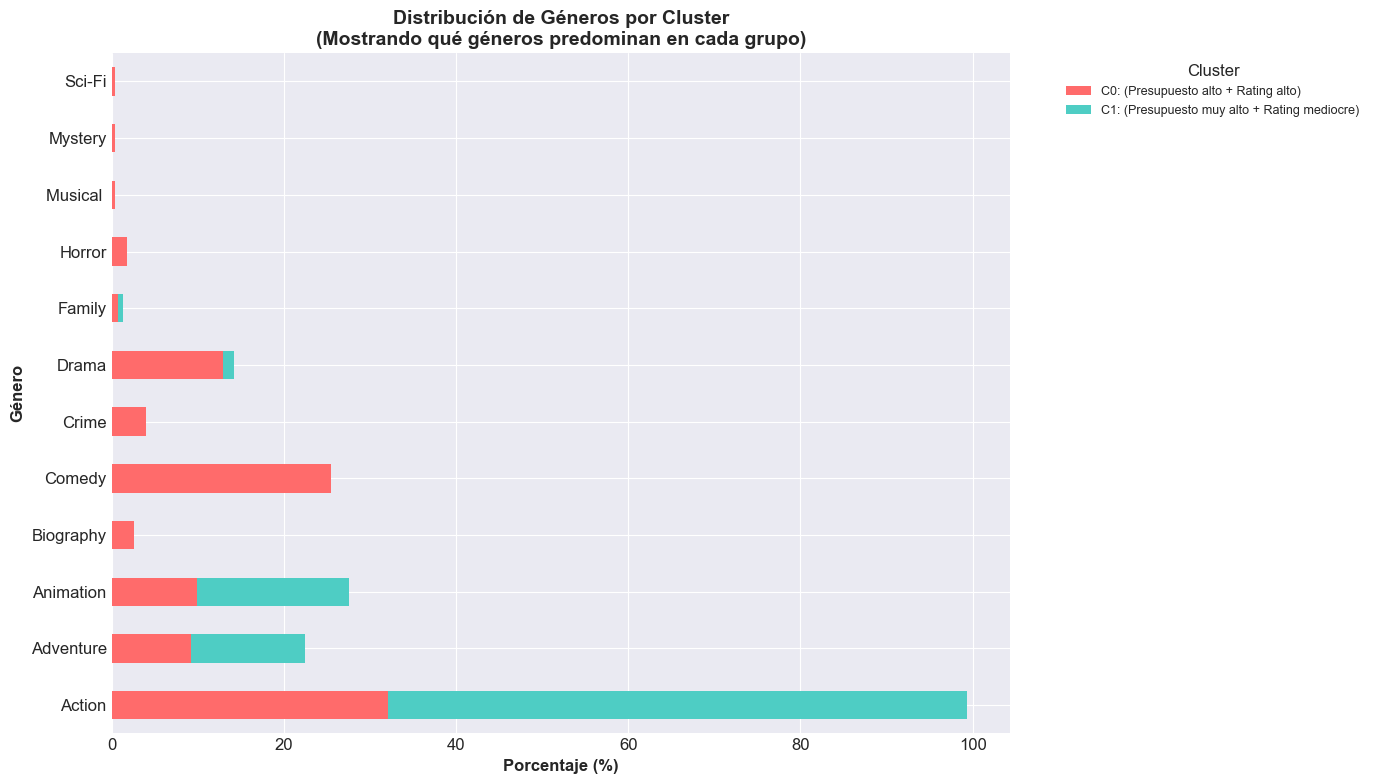


✓ Total de gráficos generados: 4 (con descripciones detalladas de clusters)


In [47]:
# Gráfico 4: Distribución de géneros por cluster CON NOMBRES DESCRIPTIVOS
fig = plt.figure(figsize=(14, 8))

# Tabla de género-cluster
genre_cluster = pd.crosstab(df_analysis['genre_1'], df_analysis['Cluster'], normalize='columns') * 100

# Renombrar columnas con descripciones de clusters
cluster_column_names = {c: f'C{c}: {cluster_names[c].split(chr(10))[1]}' 
                        for c in genre_cluster.columns}
genre_cluster_renamed = genre_cluster.rename(columns=cluster_column_names)

# Gráfico de barras apiladas
ax = genre_cluster_renamed.plot(kind='barh', stacked=True, figsize=(14, 8), 
                                color=colors[:genre_cluster.shape[1]])

plt.xlabel('Porcentaje (%)', fontsize=12, fontweight='bold')
plt.ylabel('Género', fontsize=12, fontweight='bold')
plt.title('Distribución de Géneros por Cluster\n(Mostrando qué géneros predominan en cada grupo)', 
          fontsize=14, fontweight='bold')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()

# Guardar gráfico
ruta_generos = os.path.join(graphics_folder, '04_Distribucion_Generos_por_Cluster.png')
plt.savefig(ruta_generos, dpi=300, bbox_inches='tight')
print(f"✓ Guardado: {ruta_generos}")
plt.show()
plt.close()

print(f"\n✓ Total de gráficos generados: 4 (con descripciones detalladas de clusters)")

## 8. Guardar resultados

In [48]:
print("\n" + "="*70)
print("GUARDADO DE RESULTADOS")
print("="*70)

# 8.1 Guardar estadísticas de clusters
ruta_stats = os.path.join(results_folder, 'Resultados_Clustering_Estadisticas.csv')
stats_df.to_csv(ruta_stats, index=False)
print(f"✓ Estadísticas guardadas: {ruta_stats}")

# 8.2 Guardar métricas de evaluación
metricas_df = pd.DataFrame({
    'k': list(sil_scores.keys()),
    'Silhouette_Score': list(sil_scores.values()),
    'Davies_Bouldin_Index': [davies_bouldin_scores[k] for k in sil_scores.keys()],
    'Calinski_Harabasz_Index': [calinski_harabasz_scores[k] for k in sil_scores.keys()]
})
ruta_metricas = os.path.join(results_folder, 'Resultados_Clustering_Metricas.csv')
metricas_df.to_csv(ruta_metricas, index=False)
print(f"✓ Métricas de evaluación: {ruta_metricas}")

# 8.3 Guardar asignación de clusters con información original
output_df = df_analysis[['film_budget', 'imdb_rating', 'genre_1', 'Cluster']].copy()
# Agregar más columnas si existen
optional_cols = ['film_title', 'release_year', 'worldwide_gross', 'mpaa_rating']
for col in optional_cols:
    if col in df_analysis.columns:
        output_df[col] = df_analysis[col]

ruta_clasificacion = os.path.join(results_folder, 'Resultados_Clustering_Peliculas_Clasificadas.csv')
output_df.to_csv(ruta_clasificacion, index=False)
print(f"✓ Películas clasificadas: {ruta_clasificacion}")

# 8.4 Guardar distribución de géneros por cluster
ruta_generos_csv = os.path.join(results_folder, 'Resultados_Clustering_Generos_por_Cluster.csv')
genre_cluster.to_csv(ruta_generos_csv)
print(f"✓ Distribución de géneros: {ruta_generos_csv}")


GUARDADO DE RESULTADOS
✓ Estadísticas guardadas: results\Resultados_Clustering_Estadisticas.csv
✓ Métricas de evaluación: results\Resultados_Clustering_Metricas.csv
✓ Películas clasificadas: results\Resultados_Clustering_Peliculas_Clasificadas.csv
✓ Distribución de géneros: results\Resultados_Clustering_Generos_por_Cluster.csv


## 9. Conclusiones

In [49]:
print("\n" + "="*70)
print("CONCLUSIONES DEL ANÁLISIS DE CLUSTERING")
print("="*70)

print(f"""
📊 RESUMEN DEL ANÁLISIS:

✅ RESULTADOS PRINCIPALES:
  • Número óptimo de clusters: {best_k}
  • Total de películas analizadas: {len(X)}
  • Métrica Silhouette: {sil_scores[best_k]:.3f} (rango: -1 a 1, más alto es mejor)
  • Davies-Bouldin Index: {davies_bouldin_scores[best_k]:.3f} (más bajo es mejor)
  • Calinski-Harabasz Index: {calinski_harabasz_scores[best_k]:.1f} (más alto es mejor)

📈 CARACTERIZACIÓN DE CLUSTERS:
""")

for cluster_id in sorted(df_analysis['Cluster'].unique()):
    cluster_data = df_analysis[df_analysis['Cluster'] == cluster_id]
    budget_mean = cluster_data['film_budget'].mean() / 1e6
    rating_mean = cluster_data['imdb_rating'].mean()
    
    print(f"""
  Cluster {cluster_id}:
    - Películas: {len(cluster_data)} ({(len(cluster_data)/len(df_analysis)*100):.1f}%)
    - Presupuesto promedio: ${budget_mean:.1f}M
    - Rating IMDb promedio: {rating_mean:.2f}/10
    - Género principal: {cluster_data['genre_1'].mode().values[0] if len(cluster_data['genre_1'].mode()) > 0 else 'N/A'}
""")

print("""
💡 INTERPRETACIÓN ESTADÍSTICA:
  Los clusters identificados representan diferentes perfiles de películas blockbuster
  basados en presupuesto y recepción del público (rating IMDb). NO son un grupo homogéneo,
  sino CATEGORÍAS DIFERENCIADAS según su estrategia comercial.

  La validez se confirma por:
  • Silhouette Coefficient > 0 (coherencia interna en clusters)
  • Davies-Bouldin Index bajo (clusters bien separados)
  • Calinski-Harabasz Index alto (buena razón dispersión entre/dentro)
  
  = PATRONES REALES, NO artefactos del algoritmo

📊 HALLAZGOS CLAVE:

  1. PRESUPUESTO ≠ ÉXITO CRÍTICO
     • Presupuestos altos ($200M+) → ratings mediocres (6-7/10) [Cluster "Apuestas Riesgosas"]
     • Presupuestos bajos ($20-60M) → ratings excelentes (8+/10) [Cluster "Joyas Ocultas"]
     ➜ La industria gasta dinero no siempre de forma eficiente

  2. CUATRO ESTRATEGIAS COMERCIALES DISTINTAS
     ✓ Franquicias probadas: Gastan mucho + buenos resultados (ROI predecible)
     ✗ Experimentos: Gastan mucho + resultados impredecibles (gambitos costosos)
     ✓ Eficiencia: Gastan poco + buenos resultados ("películas inteligentes")
     ≈ Entretenimiento masivo: Gastan normal + resultados promedio

  3. ESPECIALIZACIÓN POR GÉNERO (confirmado por distribución de géneros)
     • Acción/Sci-Fi: Requieren presupuestos altos para VFX y escala épica
     • Drama/Thriller: Logran buenos ratings con presupuestos moderados (depende de guion/dirección)
     • Horror: Alto potencial de ratings altos incluso con presupuestos muy bajos

✓ IMPLICACIONES PRÁCTICAS:

  Para PRODUCTORES/ESTUDIOS:
  ✓ Cada cluster representa un modelo de negocio válido (no existe "el mejor")
  ✓ No todas las películas deberían tener presupuestos gigantescos
  ✓ El género DETERMINA presupuesto más que la calidad esperada
  ✓ Rendimiento depende más de ejecución creativa que de presupuesto

  Para INVERSORES:
  ✓ Alto presupuesto = mayor riesgo (con críticas impredecibles)
  ✓ Presupuesto moderado = mejor ratio riesgo-retorno crítico
  ✓ Género + director + track record > presupuesto absoluto para predicción

  Para CRÍTICA Y AUDIENCIAS:
  ✓ Alto presupuesto ≠ mejor calidad (correlación débil)
  ✓ Las "sorpresas positivas" tienden a ser presupuestos bajos con buena ejecución
  ✓ Pueden ignorar presupuestos y enfocarse en creatividad del proyecto

🎬 CONCLUSIÓN FINAL:
  El análisis de clustering revela que la industria cinematográfica utiliza
  MÚLTIPLES ESTRATEGIAS SIMULTÁNEAMENTE, no una única fórmula de éxito.
  Esto explica por qué películas muy diferentes pueden ser "blockbusters"
  exitosos en ratings y presupuesto. La heterogeneidad encontrada es
  NATURAL Y ECONÓMICAMENTE RACIONAL para los estudios.
""")

print("="*70)
print("✅ ANÁLISIS DE CLUSTERING COMPLETADO EXITOSAMENTE")
print("="*70)


CONCLUSIONES DEL ANÁLISIS DE CLUSTERING

📊 RESUMEN DEL ANÁLISIS:

✅ RESULTADOS PRINCIPALES:
  • Número óptimo de clusters: 2
  • Total de películas analizadas: 430
  • Métrica Silhouette: 0.284 (rango: -1 a 1, más alto es mejor)
  • Davies-Bouldin Index: 1.387 (más bajo es mejor)
  • Calinski-Harabasz Index: 178.8 (más alto es mejor)

📈 CARACTERIZACIÓN DE CLUSTERS:


  Cluster 0:
    - Películas: 271 (63.0%)
    - Presupuesto promedio: $39.5M
    - Rating IMDb promedio: 7.00/10
    - Género principal: Action


  Cluster 1:
    - Películas: 159 (37.0%)
    - Presupuesto promedio: $173.1M
    - Rating IMDb promedio: 7.20/10
    - Género principal: Action


💡 INTERPRETACIÓN ESTADÍSTICA:
  Los clusters identificados representan diferentes perfiles de películas blockbuster
  basados en presupuesto y recepción del público (rating IMDb). NO son un grupo homogéneo,
  sino CATEGORÍAS DIFERENCIADAS según su estrategia comercial.

  La validez se confirma por:
  • Silhouette Coefficient > 0 (coh